In [1]:
import os
os.chdir(path='../../')
import umap
import scanpy as sc
import plotly.express as px
import matplotlib.pyplot as plt
import STForte.helper as stfhelper
from plotly.subplots import make_subplots
from plotly.colors import convert_to_RGB_255
from sklearn.preprocessing import minmax_scale
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=16)
trial_name = "trial-DLPFC-pca/151673"
palette = px.colors.qualitative.Plotly
plot_dir = f"./{trial_name}/plots"
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]

Global seed set to 0


In [2]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'STForte_Mask', 'mclust_STForte_COMB'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'mclust_STForte_COMB_colors', 'neighbors', 'spatial', 'spatialLIBD_colors', 'umap'
    obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [3]:
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata_sp

AnnData object with n_obs × n_vars = 14201 × 300
    obs: 'spot_instance', 'mclust_STForte_COMB_with_padding', 'spatialLIBD_with_padding'
    uns: 'mclust_STForte_COMB_with_padding_colors', 'neighbors', 'spatialLIBD_with_padding_colors', 'spot_instance_colors', 'umap'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'X_umap', 'spatial'
    obsp: 'A_STForte_conn', 'A_STForte_recon', 'connectivities', 'distances'

In [4]:
import plotly.graph_objects as go
import numpy as np

labels = ["Observed", "Inferred"]
num_observed = len(adata_sp[adata_sp.obs['spot_instance'] == 'Observed'])
num_inferred = len(adata_sp[adata_sp.obs['spot_instance'] == 'Inferred'])
widths = np.array([50, 50])


dd_1 = dict(map(lambda cc: [cc, 
                          [(adata_sp[adata_sp.obs['spot_instance'] == 'Observed'].obs['mclust_STForte_COMB_with_padding'] == cc).sum() / num_observed,
                           (adata_sp[adata_sp.obs['spot_instance'] == 'Inferred'].obs['mclust_STForte_COMB_with_padding'] == cc).sum() / num_inferred
                           ]],
         adata.obs['mclust_STForte_COMB'].cat.categories))
dn_1 = dict(map(lambda cc: [cc,
                          [[cc, cc],
                           [(adata_sp[adata_sp.obs['spot_instance'] == 'Observed'].obs['mclust_STForte_COMB_with_padding'] == cc).sum(),
                           (adata_sp[adata_sp.obs['spot_instance'] == 'Inferred'].obs['mclust_STForte_COMB_with_padding'] == cc).sum()
                           ]]],
         adata.obs['mclust_STForte_COMB'].cat.categories))
dd_2 = dict(map(lambda cc: [cc, 
                          [(adata_sp[adata_sp.obs['spot_instance'] == 'Observed'].obs['spatialLIBD_with_padding'] == cc).sum() / num_observed,
                           (adata_sp[adata_sp.obs['spot_instance'] == 'Inferred'].obs['spatialLIBD_with_padding'] == cc).sum() / num_inferred
                           ]],
         adata.obs['spatialLIBD'].cat.categories))
dn_2 = dict(map(lambda cc: [cc,
                          [[cc, cc],
                           [(adata_sp[adata_sp.obs['spot_instance'] == 'Observed'].obs['spatialLIBD_with_padding'] == cc).sum(),
                           (adata_sp[adata_sp.obs['spot_instance'] == 'Inferred'].obs['spatialLIBD_with_padding'] == cc).sum()
                           ]]],
         adata.obs['spatialLIBD'].cat.categories))

fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.32,
                    subplot_titles=("STForte (Clustering Results)", "Ground Truth"))
for ii, key in enumerate(dd_1):
    fig.add_trace(go.Bar(
        name=key,
        x=dd_1[key],
        y=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        customdata=np.array(dn_1[key]).T,
        texttemplate="%{x:.0%}",
        textposition="inside",
        legendgroup=f"legend{ii}",
        # textangle=0,
        textfont_color="#fffff8",
        textfont_size=16,
        marker_color=px.colors.qualitative.Plotly[ii],
        marker_line=dict(color="#444", width=1.),
        orientation='h',
    ),row=1, col=1)
for ii, key in enumerate(dd_2):
    fig.add_trace(go.Bar(
        name=key,
        x=dd_2[key],
        y=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        customdata=np.array(dn_2[key]).T,
        texttemplate="%{x:.0%}",
        textposition="inside",
        legendgroup=f"legend{ii}",
        # textangle=0,
        textfont_color="#fffff8",
        textfont_size=12,
        marker_color=px.colors.qualitative.Bold[ii],
        marker_line=dict(color="#444", width=1.),
        orientation='h'
    ),row=2, col=1)
    
fig.update_yaxes(
    tickvals=np.cumsum(widths)-widths/2,
    ticktext= ["%s (%d)" % (l, w) for l, w in zip(labels, np.array([num_observed, num_inferred]))]
)

fig.update_xaxes(range=[0, 1], tickvals=(0, 1), ticktext=("0%", "100%"),
                 showticklabels=True)
fig.update_xaxes(side="top", row=1, col=1)
fig.update_yaxes(range=[0, 100])

fig.update_layout(
    width=600, height=280,
    barmode="stack",
    legend=dict(
        orientation="h",
        entrywidth=15,
        traceorder="grouped",
        x=0.5,
        xanchor="center",
        yanchor="middle",
        y=0.5,
        bgcolor="rgba(0, 0, 0, 0)",
        tracegroupgap=8,
        valign="top",
    ),
    uniformtext=dict(mode="hide", minsize=10),
    font_family="Arial",
    font_size=16,
    plot_bgcolor="rgba(23, 32, 32, .5)",
    paper_bgcolor="rgba(0, 0, 0, 0)",
    margin=dict(l=10,r=10,b=40,t=40),
)
fig.update_annotations(font_size=20)
fig['layout']['annotations'][1]['y'] = -0.15
fig.write_image(f"{plot_dir}/barplot_label_padding.pdf")
fig

In [5]:
embedder = umap.UMAP(n_components=3, random_state=42)
embedding = embedder.fit_transform(adata.obsm["STForte_COMB"])
embedding = minmax_scale(embedding)
embedder = umap.UMAP(n_components=3, random_state=42)
embed_sp_topo = embedder.fit_transform(adata_sp.obsm["SP_TOPO"])
embed_sp_topo = minmax_scale(embed_sp_topo)
embedder = umap.UMAP(n_components=3, random_state=42)
embed_sp_attr = embedder.fit_transform(adata_sp.obsm["SP_ATTR_FP"])
embed_sp_attr = minmax_scale(embed_sp_attr)
embedder = umap.UMAP(n_components=3, random_state=42)
embed_sp_comb = embedder.fit_transform(adata_sp.obsm["SP_COMB"])
embed_sp_comb = minmax_scale(embed_sp_comb)

In [6]:
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap, log_cmap
from bokeh.io import output_notebook

In [7]:
output_notebook()

Loading BokehJS ...

In [8]:
p1 = figure()
p1.hex(adata.obsm['spatial'][:, 0], -adata.obsm['spatial'][:, 1],
        #    fill_color=np.array([convert_to_RGB_255(embedding[ii]) for ii in range(embedding.shape[0])]),
           fill_color=embedding, angle=60,
           size=10,
           line_color=None,
           
           )
show(p1)

In [9]:
fig = make_subplots(rows=1, cols=4,
                    subplot_titles=("Source", "SP_TOPO", "SP_ATTR_FP", "SP_COMB"))
fig.add_trace(
    go.Scatter(
        x=adata.obsm['spatial'][:, 0],
        y=-adata.obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embedding[ii])}" for ii in range(embedding.shape[0])]),
        marker_size=6.0,
        mode="markers",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=2.8,
        marker_line_width=0.8,
        marker_line_color="#404040",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=2.8,
        marker_line_width=0.8,
        marker_line_color="#404040",
    ),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=4
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=2.8,
        marker_line_width=0.8,
        marker_line_color="#404040",
    ),
    row=1, col=4
)
for ii in range(1, 4+1):
    fig.update_xaxes(visible=False, row=1, col=ii)
    fig.update_yaxes(visible=False, row=1, col=ii)
fig.update_traces(
    marker=dict(symbol="hexagon"),
    selector=dict(mode="markers"), 
)
fig.update_layout(width=1600, height=520, 
                    minreducedwidth=500,
                    minreducedheight=500,
                    showlegend=False, template="plotly_white")
fig.update_annotations(font_size=24)
fig.update_layout(font_size=18, font_family="Arial",
                  margin=dict(l=10,r=10,b=100,t=50),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  paper_bgcolor="rgba(0, 0, 0, 0)",)

stfhelper.pl.show_static_figure(fig, scale=2.0)
fig.write_image(f"{plot_dir}/rgb_compare_all.pdf")

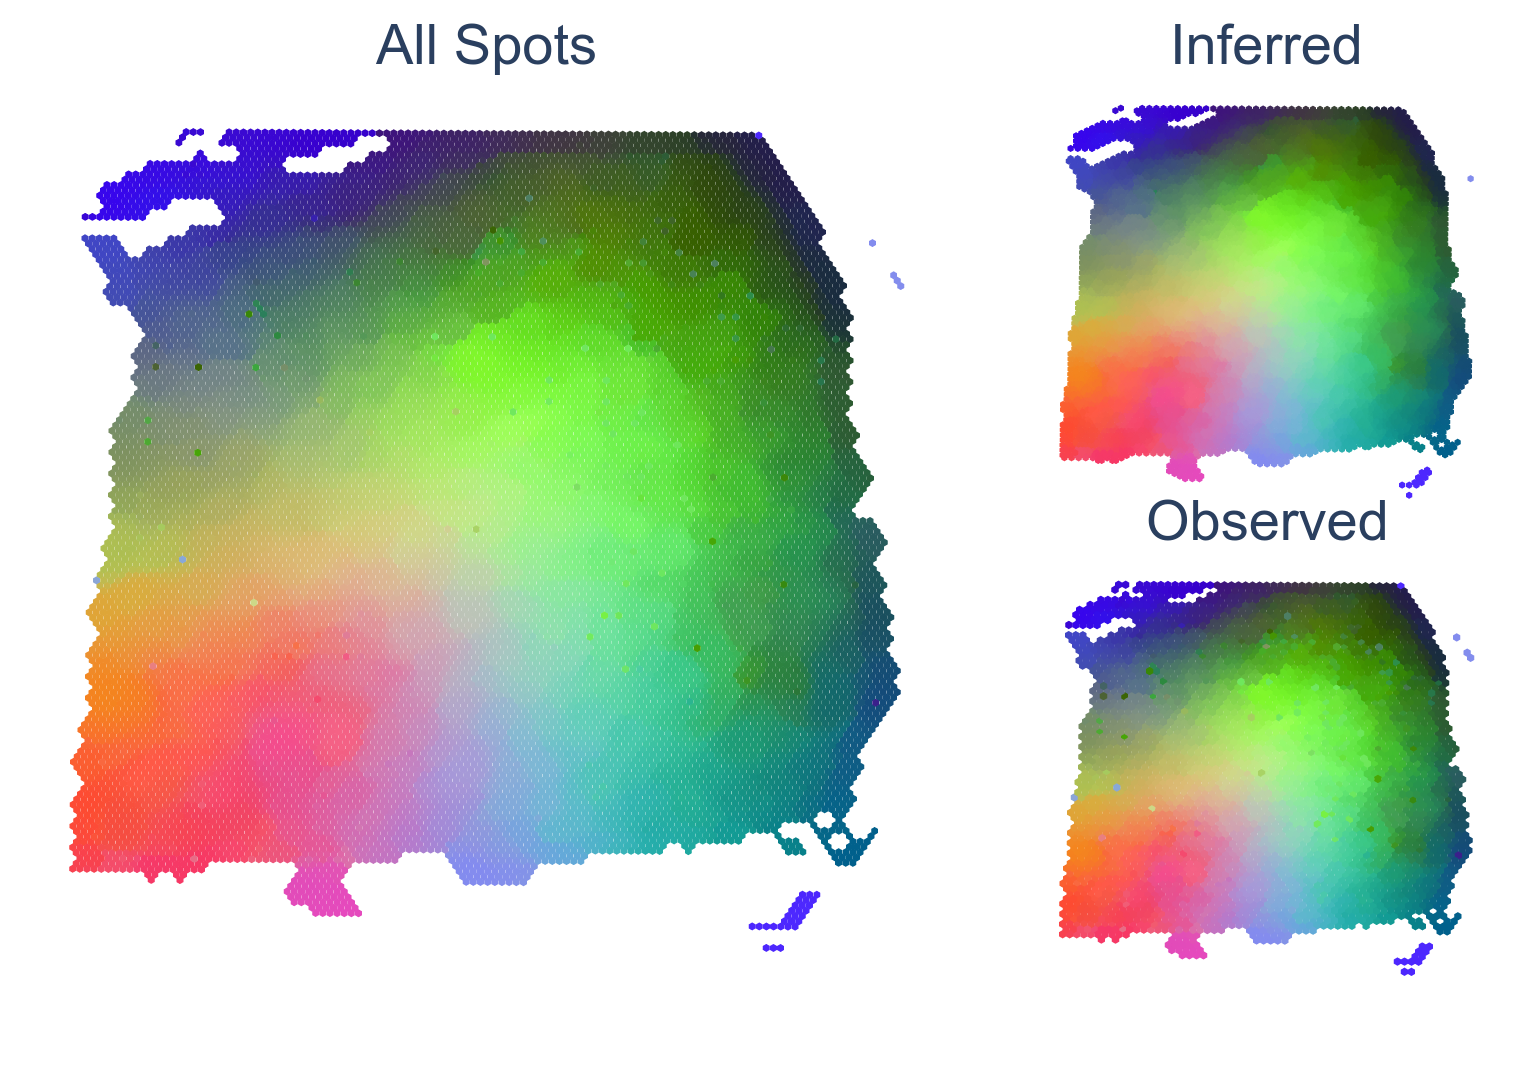

In [10]:
fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.4, 0.2],
                    row_heights=[0.435, 0.435],
                    specs=[[{"rowspan": 2}, {}],
                            [None, {}]],
                    vertical_spacing=0.036,
                    horizontal_spacing=0.054,
                    subplot_titles=["All Spots", "Inferred", "Observed"])
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=4.0,
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=4.0,
        # marker_line_width=0.2,
        # marker_line_color="#404040",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=4.2,
    ),
    row=2, col=2
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_traces(
    marker=dict(symbol="hexagon"),
    selector=dict(mode="markers"), 
)
fig.update_layout(
    width=760, height=540, 
                    # minreducedwidth=520,
                    # minreducedheight=520,
                    showlegend=False, template="plotly_white")
fig.update_layout(font_size=18, font_family="Arial",
                  margin=dict(l=10,r=10,b=40,t=40),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  paper_bgcolor="rgba(0, 0, 0, 0)",
                  )
fig.update_annotations(font_size=28)
fig.update_annotations(font_size=28, row=2, col=2, y=0.4)
fig.write_image(f"{plot_dir}/rgb_comb.pdf")
stfhelper.pl.show_static_figure(fig, scale=2)

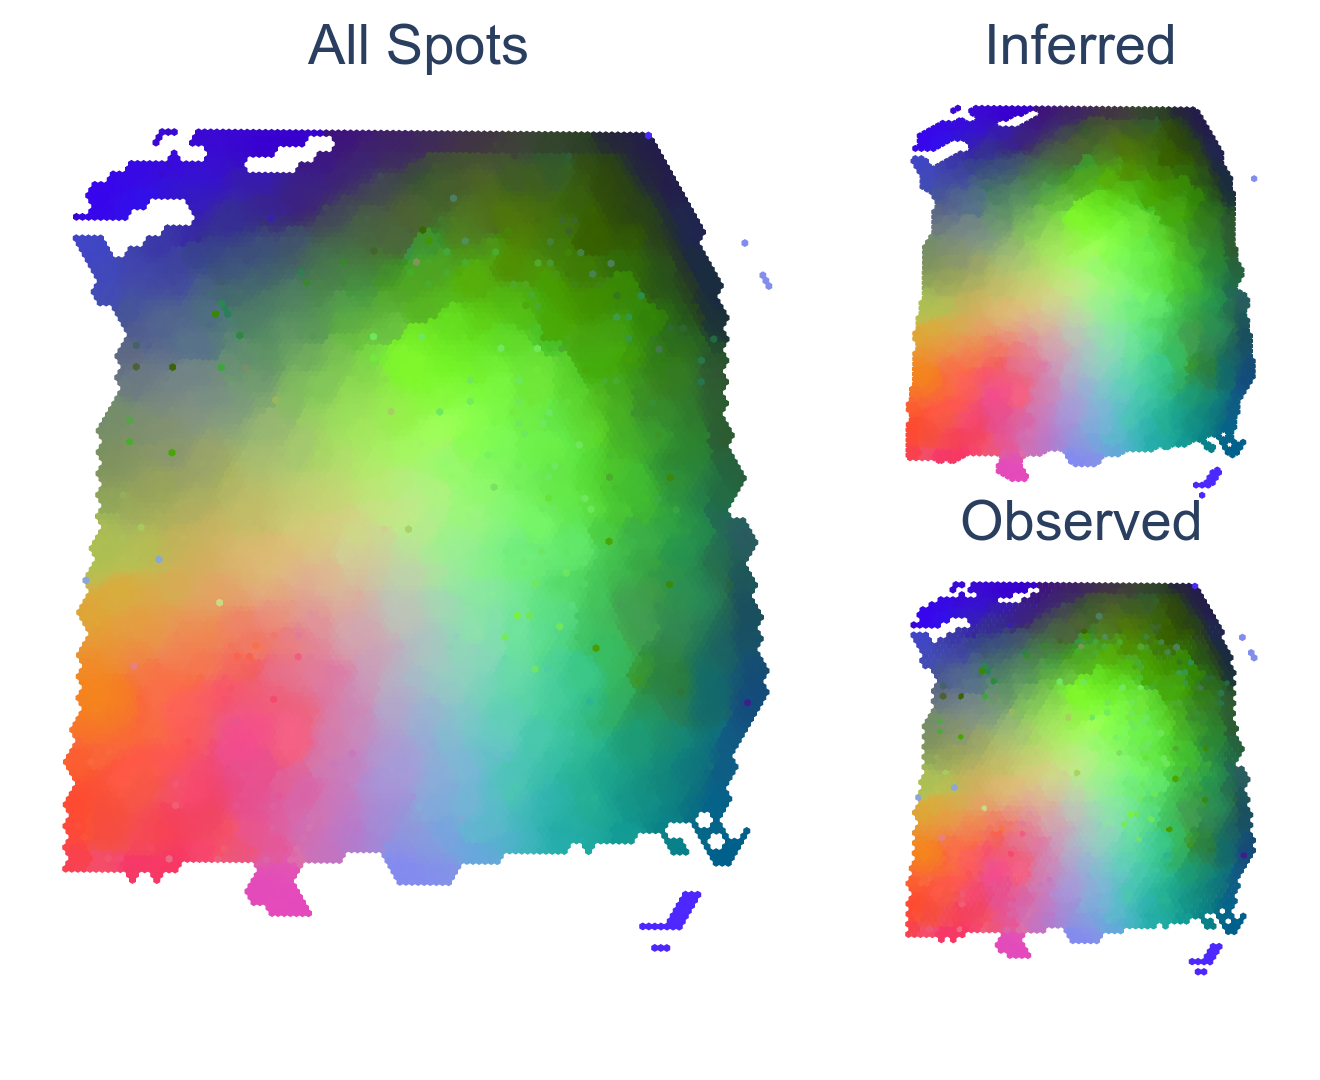

In [11]:
fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.4, 0.2],
                    row_heights=[0.435, 0.435],
                    specs=[[{"rowspan": 2}, {}],
                            [None, {}]],
                    vertical_spacing=0.036,
                    horizontal_spacing=0.054,
                    subplot_titles=["All Spots", "Inferred", "Observed"])
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=4.0,
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=4.0,
        # marker_line_width=0.0,
        # marker_line_color="#404040",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_comb[ii])}" for ii in range(embed_sp_comb.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=3.8,
    ),
    row=2, col=2
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_traces(
    marker=dict(symbol="hexagon"),
    selector=dict(mode="markers"), 
)
fig.update_layout(
    width=660, height=540,
                    minreducedwidth=520,
                    minreducedheight=520,
                    showlegend=False, template="plotly_white")
fig.update_layout(font_size=18, font_family="Arial",
                  margin=dict(l=10,r=20,b=40,t=40),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  paper_bgcolor="rgba(0, 0, 0, 0)",
                  )
fig.update_annotations(font_size=28)
fig.update_annotations(font_size=28, row=2, col=2, y=0.4)
fig.write_image(f"{plot_dir}/rgb_comb.pdf")
stfhelper.pl.show_static_figure(fig, scale=2)

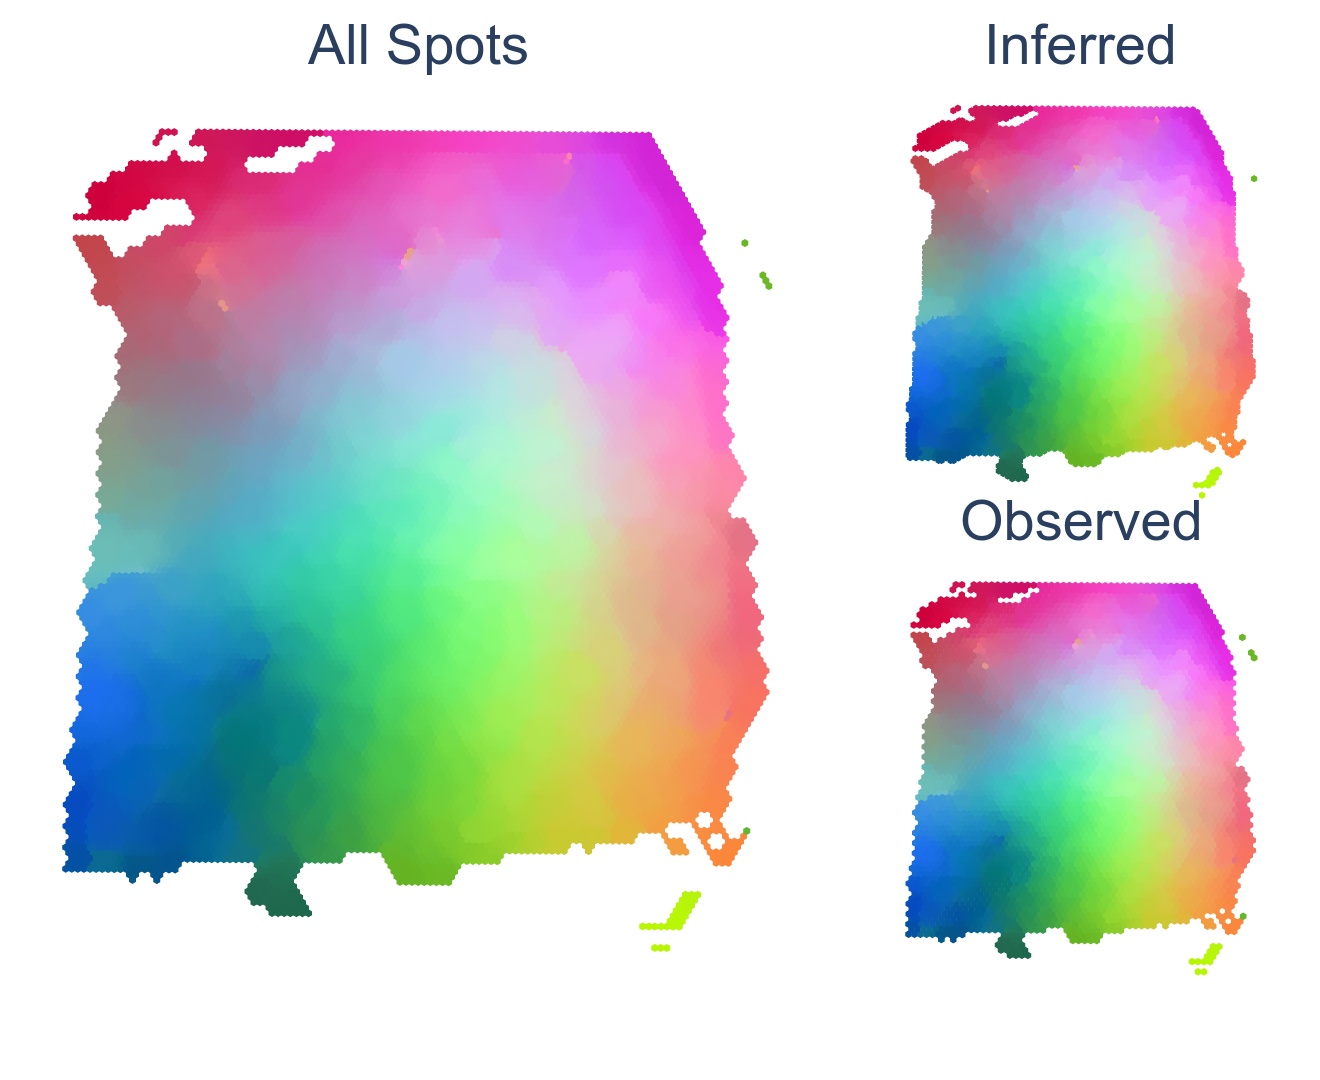

In [12]:
fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.4, 0.2],
                    row_heights=[0.435, 0.435],
                    specs=[[{"rowspan": 2}, {}],
                            [None, {}]],
                    vertical_spacing=0.036,
                    horizontal_spacing=0.054,
                    subplot_titles=["All Spots", "Inferred", "Observed"])
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=4.0,
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=4.0,
        # marker_line_width=0.0,
        # marker_line_color="#404040",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_topo[ii])}" for ii in range(embed_sp_topo.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=3.8,
    ),
    row=2, col=2
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_traces(
    marker=dict(symbol="hexagon"),
    selector=dict(mode="markers"), 
)
fig.update_layout(
    width=660, height=540,
                    minreducedwidth=520,
                    minreducedheight=520,
                    showlegend=False, template="plotly_white")
fig.update_layout(font_size=18, font_family="Arial",
                  margin=dict(l=10,r=20,b=40,t=40),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  paper_bgcolor="rgba(0, 0, 0, 0)",
                  )
fig.update_annotations(font_size=28)
fig.update_annotations(font_size=28, row=2, col=2, y=0.4)
fig.write_image(f"{plot_dir}/rgb_topo.pdf")
stfhelper.pl.show_static_figure(fig, scale=2)

In [13]:
fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.4, 0.2],
                    row_heights=[0.435, 0.435],
                    specs=[[{"rowspan": 2}, {}],
                            [None, {}]],
                    vertical_spacing=0.036,
                    horizontal_spacing=0.054,
                    subplot_titles=["All Spots", "Inferred", "Observed"])
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=4.0,
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=4.0,
        # marker_line_width=0.2,
        # marker_line_color="#404040",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Inferred"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Inferred"],
        mode="markers",
        marker_size=3.6,
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 0],
        y=-adata_sp[adata_sp.obs["spot_instance"] == "Observed"].obsm['spatial'][:, 1],
        marker_color=np.array([f"rgb{convert_to_RGB_255(embed_sp_attr[ii])}" for ii in range(embed_sp_attr.shape[0])])[adata_sp.obs["spot_instance"] == "Observed"],
        mode="markers",
        marker_size=3.8,
    ),
    row=2, col=2
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_traces(
    marker=dict(symbol="hexagon"),
    selector=dict(mode="markers"), 
)
fig.update_layout(
    width=660, height=540, 
                    minreducedwidth=520,
                    minreducedheight=520,
                    showlegend=False, template="plotly_white")
fig.update_layout(font_size=18, font_family="Arial",
                  margin=dict(l=10,r=20,b=40,t=40),
                  plot_bgcolor="rgba(0, 0, 0, 0)",
                  paper_bgcolor="rgba(0, 0, 0, 0)",
                  )
fig.update_annotations(font_size=28)
fig.update_annotations(font_size=28, row=2, col=2, y=0.4)
fig.write_image(f"{plot_dir}/rgb_attr.pdf")